In [8]:
# Импортируем библиотеки
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

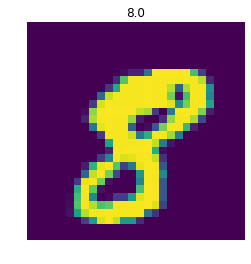

In [9]:
# Подготовка датасета
# Загрузить данные
train = pd.read_csv(r"./train.csv",dtype = np.float32)

# Разобьем данные на пиксели(features) и классы на которые будем делить(цифры от 0 до 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # Нормализация

# train test split.  Размер тестовый = 0.2, соответсвенно тренировочный будет 0.8. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# Создадим feature и целевой тензор для тренировочного датасета.
# Для того чтобы переменные могли аккумулировать градиенты, мы должны создать тензор в котором они будут хранится.
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) 

# Аналогично для тестового датасета.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

# batch_size == размер батча, epoch == количество эпох обучения и iteration == количество итераций
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Датасет в Pytorch 
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# создадим загрузчик данных в PyTorch - data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# Визуализируем одно из изображений
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [10]:
# Импорт библиотек
import torch
import torch.nn as nn
from torch.autograd import Variable

In [11]:
# Создание ANN модели
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(ANNModel, self).__init__()
        
        # Линейная функция 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Не линейная функция 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Не линейная функция 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Не линейная функция 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Линейная функция 1
        out = self.fc1(x)
        # Не линейная функция 1
        out = self.relu1(out)
        
        # Линейная функция 2
        out = self.fc2(out)
        # Не линейная функция 2
        out = self.tanh2(out)
        
        # Линейная функция 2
        out = self.fc3(out)
        # Не линейная функция 2
        out = self.elu3(out)
        
        # Линейная функция 4 (readout)
        out = self.fc4(out)
        return out

# Зададим параметры сети ANN
input_dim = 28*28
hidden_dim1 = 50 #Размерности скрытых слоев это гиперпараметры которые настраиваются во время обучения. 150 было выбрано произвольно
hidden_dim2 = 200
hidden_dim3 = 74
hidden_dim4 = 115
output_dim = 10

# Создадим экземпляр ANN
model = ANNModel(input_dim, hidden_dim1, hidden_dim2, hidden_dim3,hidden_dim4, output_dim)

# Зададим loss функцию как кросс энтропию
error = nn.CrossEntropyLoss()

# SGD оптимизатор
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# Обучение модели
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Обнулим градиенты
        optimizer.zero_grad()
        
        # Проведем forward propagation
        outputs = model(train)
        
        # Посчитаем loss функцию 
        loss = error(outputs, labels)
        
        # Расчитаем градиенты
        loss.backward()
        
        # Обновим параметры сети
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Подсчет точности        
            correct = 0
            total = 0
            # Работа с тестовым датасетом
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Проведем Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # Сохраним loss и iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Выведем Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7460307478904724  Accuracy: 79.42857360839844 %
Iteration: 1000  Loss: 0.45754361152648926  Accuracy: 87.89286041259766 %
Iteration: 1500  Loss: 0.24368451535701752  Accuracy: 89.28571319580078 %
Iteration: 2000  Loss: 0.2963241934776306  Accuracy: 90.36904907226562 %
Iteration: 2500  Loss: 0.3275548815727234  Accuracy: 91.55952453613281 %
Iteration: 3000  Loss: 0.13101787865161896  Accuracy: 92.22618865966797 %
Iteration: 3500  Loss: 0.24853023886680603  Accuracy: 93.11904907226562 %
Iteration: 4000  Loss: 0.07540720701217651  Accuracy: 93.54762268066406 %
Iteration: 4500  Loss: 0.33215683698654175  Accuracy: 94.17857360839844 %
Iteration: 5000  Loss: 0.10649619996547699  Accuracy: 94.46428680419922 %
Iteration: 5500  Loss: 0.1822831779718399  Accuracy: 94.67857360839844 %
Iteration: 6000  Loss: 0.2215009182691574  Accuracy: 94.89286041259766 %
Iteration: 6500  Loss: 0.09835625439882278  Accuracy: 95.42857360839844 %
Iteration: 7000  Loss: 0.12337236106395721  

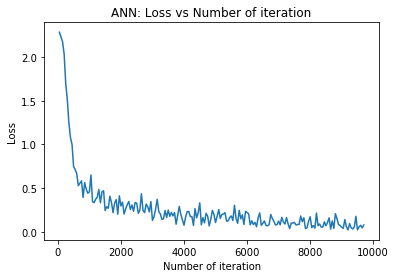

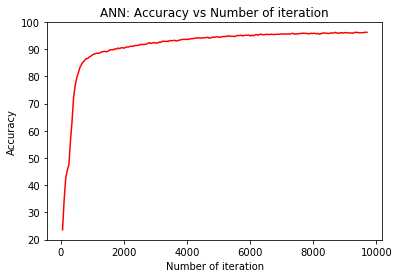

In [13]:
# Визуализация loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# Визуализация accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()